# 1. Import Required Libraries

In [1]:
# pyarrow kütüphanesini yüklemek için:
# !pip install pyarrow

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib
import graphviz
import plotly.graph_objects as go
from scipy import stats
from datetime import date

# Scikit-Learn utilities and models
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer

# Gradient Boosting Classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Set warnings to ignore
warnings.simplefilter(action="ignore")

# 2. Adjusting Row Column Settings

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# Parquet dosyasını oku
submission_data = pd.read_parquet('/kaggle/input/turkiye-is-bankasi-ml-challenge-5/submission_sample_final.parquet', engine='pyarrow')

In [5]:
submission_data.head()

,id,target
0,2e6105f5911256f4f6c4813ed,
1,c56ad71dae0a5dbd3e7d36adc,
2,4d02ea175f6581f0c6385311f,
3,3412d27a86c286ba078fa935c,
4,0203b561f6f7e10eafa46eefa,


In [6]:
test_data = pd.read_parquet('/kaggle/input/turkiye-is-bankasi-ml-challenge-5/test_final.parquet', engine='pyarrow')

In [7]:
test_data.head()

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,2e6105f5911256f4f6c4813ed,1,6893.544,246.854,242.636,VODAFONE TR,samsung,-1.724,3.216,-1.138,2.027,2.242,1.796,-0.213,0.448,3.465,-4.220,-0.932,3.634,-0.555,-2.298,0.511,-0.383,-2.593,-2.447,0.924,-0.411,0.246,2.258,3.600,-1.498,0.517,0.663,1.871,0.861,-1.025,-2.007,0.210,-0.098,-2.986,-0.042,3.813,-4.685,-0.250,2.277,-0.368,-1.725,-1.095,-1.217,-4.280,1.512,-2.306,2.066,0.845,-1.026,18,58
1,c56ad71dae0a5dbd3e7d36adc,1,4481.065,740.209,263.860,TURKCELL,Apple,-0.417,2.024,0.103,-1.634,3.622,1.506,1.994,0.434,0.706,-3.248,-0.745,-0.762,3.167,1.195,3.198,-0.675,-0.556,-1.830,-1.155,-1.771,2.685,0.858,-0.147,0.130,0.208,0.972,0.356,-3.598,1.381,-1.655,-0.318,2.264,-0.277,0.789,-1.020,-6.364,0.657,0.664,-2.565,-1.020,1.806,-3.478,-2.065,1.500,1.285,0.189,-1.563,-1.902,3,35
2,4d02ea175f6581f0c6385311f,1,4340.702,2742.163,318.700,TURKCELL,samsung,-2.943,2.770,0.735,1.681,3.229,2.712,1.076,0.105,1.276,-4.785,-0.621,0.928,2.831,-0.420,3.244,-1.674,-2.557,-2.590,-0.821,-0.832,0.729,2.416,-1.964,0.121,-0.611,-1.603,0.149,-1.517,1.762,-1.741,0.819,2.675,-0.724,0.716,0.687,-5.850,0.465,1.287,-0.685,-2.195,1.759,-2.039,-2.067,2.141,0.055,0.085,-1.010,-2.058,7,50
3,3412d27a86c286ba078fa935c,1,4129.666,181.397,155.423,TURK TELEKOM,Apple,-2.347,2.685,0.168,-1.072,4.971,1.387,0.516,0.622,-0.354,-2.958,-1.216,-1.326,2.019,-0.830,4.687,-2.995,-2.031,-1.833,-0.960,-2.212,1.965,0.470,-0.861,-0.312,1.205,-0.673,1.095,-0.621,0.803,-2.377,-0.371,3.786,-0.030,0.884,-0.862,-5.115,1.867,-0.373,-1.930,-1.264,2.172,-0.925,-1.484,0.666,0.912,0.616,0.092,-1.875,22,47
4,0203b561f6f7e10eafa46eefa,1,3903.944,126.133,100.060,TURKCELL,POCO,-1.745,2.356,0.319,-0.571,4.057,2.005,0.516,1.298,0.469,-4.918,-1.604,-1.476,2.010,-0.815,3.730,-1.009,-2.430,-1.782,-0.570,-2.180,1.449,1.126,0.684,0.001,0.960,0.683,0.881,-1.495,-0.546,-0.780,0.166,2.891,-0.309,1.652,0.846,-6.147,1.068,1.001,-3.929,-0.658,-0.373,-0.016,-2.961,1.301,1.375,-0.107,0.924,-1.606,29,52


In [8]:
train_data = pd.read_parquet('/kaggle/input/turkiye-is-bankasi-ml-challenge-5/train_final.parquet', engine='pyarrow')

In [9]:
train_data.shape

(94049, 58)

In [10]:
train_data.head(1)

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE TR,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,"menu2, menu4, menu5"


# For train_data

# Feature Engineering and Extruction

In [11]:
# train_data['IsMenu1'] = train_data['target'].apply(lambda x: 1 if 'menu1' in x else 0)
# train_data['IsMenu2'] = train_data['target'].apply(lambda x: 1 if 'menu2' in x else 0)
# train_data['IsMenu3'] = train_data['target'].apply(lambda x: 1 if 'menu3' in x else 0)
# train_data['IsMenu4'] = train_data['target'].apply(lambda x: 1 if 'menu4' in x else 0)
# train_data['IsMenu5'] = train_data['target'].apply(lambda x: 1 if 'menu5' in x else 0)
# train_data['IsMenu6'] = train_data['target'].apply(lambda x: 1 if 'menu6' in x else 0)
# train_data['IsMenu7'] = train_data['target'].apply(lambda x: 1 if 'menu7' in x else 0)
# train_data['IsMenu8'] = train_data['target'].apply(lambda x: 1 if 'menu8' in x else 0)
# train_data['IsMenu9'] = train_data['target'].apply(lambda x: 1 if 'menu9' in x else 0)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

# 'target' sütununu virgülle ayır ve listeye çevir
train_data['target'] = train_data['target'].str.split(', ')

# MultiLabelBinarizer ile 'target' sütununu binarize edin
mlb = MultiLabelBinarizer()
target_binarized = mlb.fit_transform(train_data['target'])

# Binarize edilmiş target değerlerini DataFrame'e çevir ve sütun isimlerini ayarla
target_df = pd.DataFrame(target_binarized, columns=mlb.classes_)

# Binarize edilmiş target değerlerini göster
target_df.head(1)

,menu1,menu2,menu3,menu4,menu5,menu6,menu7,menu8,menu9
0,0,1,0,1,1,0,0,0,0


In [13]:
# 'target' sütununu train_data veri setinden kaldır
train_data = train_data.drop(columns=['target'])

# 'target' sütunu kaldırıldıktan sonra train_data'nın ilk beş satırını göster
train_data.head(1)

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE TR,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58


In [14]:
# 'n_seconds_1', 'n_seconds_2' ve 'n_seconds_3' sütunlarının ortalamasını alarak yeni bir 'average_usage_time' sütunu oluşturun
train_data['average_usage_time'] = train_data[['n_seconds_1', 'n_seconds_2', 'n_seconds_3']].mean(axis=1)

# Veri çerçevesinin güncellenmiş halini göstermek için ilk beş satırı yazdırın
train_data.head(1)

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,average_usage_time
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE TR,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,2144.234


In [15]:
# Önemli özellikleri seç
important_features = ['feature_29', 'feature_10', 'feature_31', 'feature_0', 'feature_26', 
                      'feature_11', 'feature_21', 'feature_18', 'feature_25', 'feature_16','feature_8', 'feature_44', 'feature_34', 'feature_20']

# Her satır için önemli özelliklerin ortalamasını hesapla ve yeni bir özellik oluştur
train_data['onemli_ozellikler_ortalamasi'] = train_data[important_features].mean(axis=1)

# Seçilen özellik çiftlerinin çarpımı üzerinden etkileşim özellikleri oluştur
epsilon = 1e-5
train_data['feature_29_ve_31_carpim'] = train_data['feature_29'] * train_data['feature_31']
train_data['feature_10_ve_31_carpim'] = train_data['feature_10'] * train_data['feature_31']
train_data['feature_10_31_ratio'] = train_data['feature_10'] / (train_data['feature_31'] + epsilon)
train_data["feature_9_20_21"]= train_data['feature_9'] * train_data['feature_20']*train_data['feature_21']
train_data["feature_8_11"]= train_data['feature_8'] * train_data['feature_11']
# train_data["menu8_top"]= train_data['n_seconds_1'] *train_data['n_seconds_2']*train_data['feature_29']*train_data['feature_18']*train_data['feature_1']*train_data['month'] *train_data['feature_3']*train_data['feature_14']*train_data['feature_37']
# train_data["feature_0_10"]= train_data['feature_0'] *train_data['feature_10']
# train_data["feature_36_45_33_46_34"]= train_data['feature_36'] *train_data['feature_45']*train_data['feature_33']*train_data['feature_46']*train_data['feature_34']
# train_data["feature_4_1"]= train_data['feature_4'] *train_data['feature_1']
# train_data["feature_46_06_35"]= train_data['feature_46'] *train_data['feature_6']*train_data['feature_35']
# train_data["feature_z"]= train_data['feature_21']* train_data['feature_10']* train_data['feature_29']*train_data['feature_31']*train_data['feature_18']* train_data['feature_25']* train_data['feature_23']

In [16]:
train_data.head(1)

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,average_usage_time,onemli_ozellikler_ortalamasi,feature_29_ve_31_carpim,feature_10_ve_31_carpim,feature_10_31_ratio,feature_9_20_21,feature_8_11
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE TR,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,2144.234,0.733,0.671,1.815,0.253,-10.529,-1.306


In [17]:
train_data.head(1)

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,average_usage_time,onemli_ozellikler_ortalamasi,feature_29_ve_31_carpim,feature_10_ve_31_carpim,feature_10_31_ratio,feature_9_20_21,feature_8_11
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE TR,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,2144.234,0.733,0.671,1.815,0.253,-10.529,-1.306


In [18]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] 

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car] 

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"] 

    num_cols = [col for col in num_cols if col not in num_but_cat] 
    
    print(f"Observations: {dataframe.shape[0]}") 
    print(f"Variables: {dataframe.shape[1]}") 
    print(f'cat_cols: {len(cat_cols)}') 
    print(f'num_cols: {len(num_cols)}') 
    print(f'cat_but_car: {len(cat_but_car)}') 
    print(f'num_but_cat: {len(num_but_cat)}') 


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [19]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(train_data)

Observations: 94049
Variables: 64
cat_cols: 1
num_cols: 60
cat_but_car: 3
num_but_cat: 1


In [20]:
train_data.head(1)

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,average_usage_time,onemli_ozellikler_ortalamasi,feature_29_ve_31_carpim,feature_10_ve_31_carpim,feature_10_31_ratio,feature_9_20_21,feature_8_11
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE TR,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,2144.234,0.733,0.671,1.815,0.253,-10.529,-1.306


In [21]:
cat_cols

['month']

In [22]:
cat_cols =[]

In [23]:
num_cols = num_cols + ["month"]

In [24]:
cat_but_car

['id', 'carrier', 'devicebrand']

In [25]:
cat_but_car = ["id"]

In [26]:
num_but_cat

['month']

In [27]:
num_but_cat = []

# Outlier Analysis

In [28]:
def outlier_thresholds(dataframe, col_name, q1=0.14, q3=0.86):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [29]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [30]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [31]:
for col in num_cols:
    if check_outlier(train_data, col):
        replace_with_thresholds(train_data, col)

# Encoding

In [32]:
from sklearn.preprocessing import LabelEncoder

top_n = 15

# 'carrier' için en sık rastlanan N kategoriyi seçip diğerlerini "Other" olarak kodlama
top_carriers = train_data["carrier"].value_counts().head(top_n).index.tolist()
train_data["carrier_encoded"] = train_data["carrier"].apply(lambda x: x if x in top_carriers else "Other")

# Label encoding uygulama
label_encoder_carrier = LabelEncoder()
train_data["carrier_encoded"] = label_encoder_carrier.fit_transform(train_data["carrier_encoded"])

# 'devicebrand' için en sık rastlanan N kategoriyi seçip diğerlerini "Other" olarak kodlama
top_devicebrand = train_data["devicebrand"].value_counts().head(20).index.tolist()
train_data["devicebrand_encoded"] = train_data["devicebrand"].apply(lambda x: x if x in top_devicebrand else "Other")

# Label encoding uygulama
label_encoder_devicebrand = LabelEncoder()
train_data["devicebrand_encoded"] = label_encoder_devicebrand.fit_transform(train_data["devicebrand_encoded"])

In [33]:
num_cols = num_cols + ["devicebrand_encoded","carrier_encoded"]

In [34]:
droplist =["carrier", "devicebrand"]

In [35]:
train_data.drop(droplist, axis=1, inplace=True)

In [36]:
train_data.head(1)

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,average_usage_time,onemli_ozellikler_ortalamasi,feature_29_ve_31_carpim,feature_10_ve_31_carpim,feature_10_31_ratio,feature_9_20_21,feature_8_11,carrier_encoded,devicebrand_encoded
0,5beefd4d2bf4a4767e0df8108,10,1610.827,723.428,205.948,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,860.321,0.733,0.671,1.815,0.253,-10.529,-1.306,14,0


# Standardization

In [37]:
scaler = RobustScaler()

In [38]:
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])

In [39]:
train_data.head(1)

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,average_usage_time,onemli_ozellikler_ortalamasi,feature_29_ve_31_carpim,feature_10_ve_31_carpim,feature_10_31_ratio,feature_9_20_21,feature_8_11,carrier_encoded,devicebrand_encoded
0,5beefd4d2bf4a4767e0df8108,-1.000,3.667,3.867,1.999,0.706,-0.831,-1.009,0.058,-1.158,0.329,0.023,1.166,1.496,-0.747,1.049,0.071,0.634,0.142,-1.716,0.581,0.850,0.368,0.582,0.203,-0.488,0.679,0.362,-0.452,-1.865,1.140,-0.224,-0.140,1.008,1.308,-0.332,-0.410,-0.486,-0.643,1.380,-0.228,-1.582,2.073,-0.266,-2.121,-0.166,-1.389,-0.158,1.322,-1.244,0.857,-0.733,0.197,0.818,0.421,3.754,2.344,1.104,0.990,1.115,-0.774,-1.072,0.750,-0.556


# LightGBM

In [40]:
from sklearn.model_selection import train_test_split

# Özellikler ve hedef değişkenlerini ayarla
X = train_data.drop(columns=['id'])
y = target_df

# Veri setini eğitim ve doğrulama setlerine ayır
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [41]:
y.head()

,menu1,menu2,menu3,menu4,menu5,menu6,menu7,menu8,menu9
0,0,1,0,1,1,0,0,0,0
1,0,0,0,1,0,0,1,1,0
2,0,1,0,1,0,0,0,1,0
3,1,1,0,0,0,1,0,0,0
4,0,1,0,0,0,1,0,1,0


In [42]:
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import jaccard_score

# Etiket sayısını al
num_labels = y_train.shape[1]

# y_train ve y_val'i numpy dizisine çevir
y_train_array = y_train.to_numpy()
y_val_array = y_val.to_numpy()

# Sınıf ağırlıklarını hesapla
label_freq = y_train.sum(axis=0)
class_weights = len(y_train) / (num_labels * label_freq)

params={
}
params['boosting_type']='dart'
#params['objective']='multiclassova'
#params['learning_rate']=.05
params['min_data_in_leaf']=300
params['feature_fraction']=0.6
params['bagging_freq']=3
params['bagging_fraction']=0.6
params['num_leaves']=50
params['max_depth']=2
params['is_unbalanced']=True
params['sample_pos_weight']=0.66
#params['dropxgboost_dart_mode']=True
params['lambda_l1']=1
# params['class_weight']={'menu1': 1.40248139697878, 'menu2': 0.4201692310441573, 'menu3': 5.549595798666431, 'menu4': 0.8076064368763632, 'menu5': 1.6583615460572718, 'menu6': 0.4823248252483448, 'menu7': 7.587044207808971, 'menu8': 1.0715636678516087, 'menu9': 1.3382424087196563}
#params['random_state']=1009
#params['n_estimators']=500

# Her etiket için bir model eğit
models = []
for label_index in range(num_labels):
    lgbm_model = LGBMClassifier(random_state=42, n_estimators=650, learning_rate=0.05,  n_jobs=-1, class_weight={0: class_weights[label_index], 1: 1})
    lgbm_model.fit(X_train, y_train_array[:, label_index])
    models.append(lgbm_model)

# Her model ile tahmin yap ve sonuçları birleştir
y_val_pred = np.zeros_like(y_val_array)
y_val_pred_proba = np.zeros_like(y_val_array, dtype=float)

zero_proba_counts = []

for label_index, model in enumerate(models):
    y_val_pred[:, label_index] = model.predict(X_val)
    y_val_pred_proba[:, label_index] = model.predict_proba(X_val)[:, 1]  # Pozitif sınıfın olasılıklarını al
    
    # Sıfır olasılıklı tahminleri kontrol et
    zero_proba_count = np.sum(y_val_pred_proba[:, label_index] == 0)
    zero_proba_counts.append(zero_proba_count)
    print(f'Label {label_index + 1} için sıfır olasılıklı tahminlerin sayısı: {zero_proba_count}')

# Jaccard score hesapla
score = jaccard_score(y_val_array, y_val_pred, average='samples')
print(f'Jaccard Score: {score}')

Label 1 için sıfır olasılıklı tahminlerin sayısı: 0
Label 2 için sıfır olasılıklı tahminlerin sayısı: 0
Label 3 için sıfır olasılıklı tahminlerin sayısı: 0
Label 4 için sıfır olasılıklı tahminlerin sayısı: 0
Label 5 için sıfır olasılıklı tahminlerin sayısı: 0
Label 6 için sıfır olasılıklı tahminlerin sayısı: 0
Label 7 için sıfır olasılıklı tahminlerin sayısı: 0
Label 8 için sıfır olasılıklı tahminlerin sayısı: 0
Label 9 için sıfır olasılıklı tahminlerin sayısı: 0
Jaccard Score: 0.5575798081061241


In [43]:
# Jaccard Score: 0.5524531024531024
    
# Jaccard Score: 0.5530471380471382

# Jaccard Score: 0.5533770031138452
    
# Jaccard Score: 0.5536514265461634   outliers 86 14

# Jaccard Score: 0.5565795802637907 n_estimator 500

In [44]:
def count_non_three_ones(df, column_name='target'):
    count = 0
    for target in df[column_name]:
        if target.count('1') != 3:
            count += 1
    return count

In [45]:
y_pred=pd.DataFrame(y_val_pred)
y_pred['target'] = y_pred.apply(lambda row: ''.join(map(str, row)), axis=1)
#y_pred.head()
count_non_three_ones(y_pred)

6188

In [46]:
y_pred.head()

,0,1,2,3,4,5,6,7,8,target
0,1,1,0,1,0,1,0,1,0,110101010
1,0,1,0,1,0,1,0,1,0,010101010
2,0,1,0,1,0,1,0,0,0,010101000
3,0,1,0,1,0,1,0,0,0,010101000
4,1,1,0,1,0,1,0,0,1,110101001


# Feature Importance

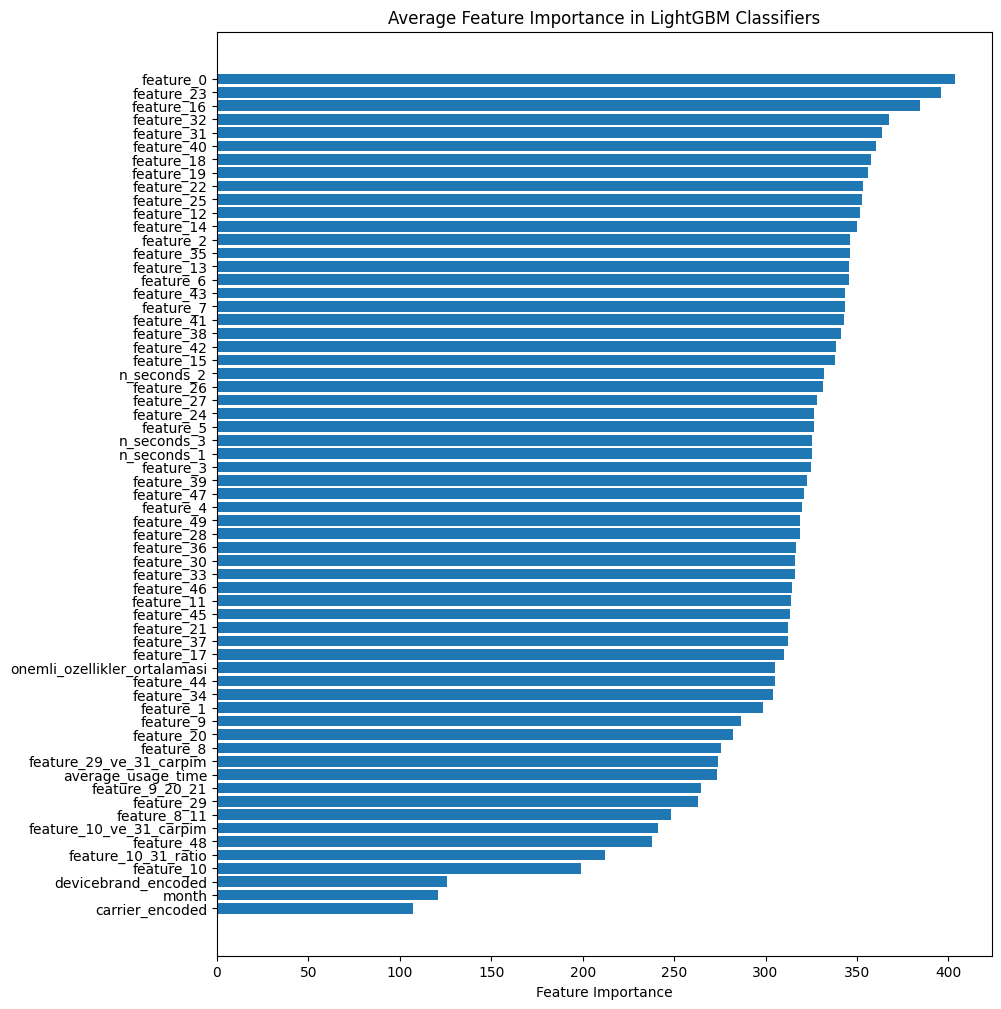

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Her model için özellik önemlerini topla
total_feature_importances = np.zeros_like(models[0].feature_importances_)

for model in models:
    total_feature_importances += model.feature_importances_

# Ortalama özellik önemlerini hesapla
average_feature_importances = total_feature_importances / num_labels

# Özellik isimleriyle eşleştir
features = X_train.columns

# Özellik önemlerini büyükten küçüğe sırala
sorted_idx = average_feature_importances.argsort()

# En önemli özellikleri ve önemlerini görselleştir
plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), average_feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Average Feature Importance in LightGBM Classifiers")
plt.show()

In [48]:
# Özellik önemlerini ve özellik isimlerini bir DataFrame'e çevir
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': average_feature_importances
})

# Özellik önemlerini büyükten küçüğe sırala
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Sıralı özellik önemlerini yazdır
print(feature_importances_df)

                         Feature  Importance
4                      feature_0     403.667
27                    feature_23     396.000
20                    feature_16     384.667
36                    feature_32     367.667
35                    feature_31     363.667
44                    feature_40     360.667
22                    feature_18     357.556
23                    feature_19     355.889
26                    feature_22     353.222
29                    feature_25     352.667
16                    feature_12     351.444
18                    feature_14     349.889
6                      feature_2     346.333
39                    feature_35     346.222
10                     feature_6     345.778
17                    feature_13     345.778
47                    feature_43     343.333
11                     feature_7     343.222
45                    feature_41     342.778
42                    feature_38     341.111
46                    feature_42     338.667
19        

# For test_data

# Featrue Engineering

In [49]:
# 1. 'n_seconds_1', 'n_seconds_2' ve 'n_seconds_3' sütunlarının ortalamasını alarak
# yeni bir 'average_usage_time' sütunu oluşturun
test_data['average_usage_time'] = test_data[['n_seconds_1', 'n_seconds_2', 'n_seconds_3']].mean(axis=1)

In [50]:
# Önemli özellikleri seç
important_features = ['feature_29', 'feature_10', 'feature_31', 'feature_0', 'feature_26', 
                      'feature_11', 'feature_21', 'feature_18', 'feature_25', 'feature_16','feature_8', 'feature_44', 'feature_34', 'feature_20']

# Her satır için önemli özelliklerin ortalamasını hesapla ve yeni bir özellik oluştur
test_data['onemli_ozellikler_ortalamasi'] = test_data[important_features].mean(axis=1)

# Seçilen özellik çiftlerinin çarpımı üzerinden etkileşim özellikleri oluştur
epsilon = 1e-5
test_data['feature_29_ve_31_carpim'] = test_data['feature_29'] * test_data['feature_31']
test_data['feature_10_ve_31_carpim'] = test_data['feature_10'] * test_data['feature_31']
test_data['feature_10_31_ratio'] = test_data['feature_10'] / (test_data['feature_31'] + epsilon)
test_data["feature_9_20_21"]= test_data['feature_9'] * test_data['feature_20']*test_data['feature_21']
test_data["feature_8_11"]= test_data['feature_8'] * test_data['feature_11']
# test_data["menu8_top"]= test_data['n_seconds_1'] *test_data['n_seconds_2']*test_data['feature_29']*test_data['feature_18']*test_data['feature_1']*test_data['month'] *test_data['feature_3']*test_data['feature_14']*test_data['feature_37']
# test_data["feature_0_10"]= test_data['feature_0'] *test_data['feature_10']


# Outlier Analysis

In [51]:
test_data.head()

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,average_usage_time,onemli_ozellikler_ortalamasi,feature_29_ve_31_carpim,feature_10_ve_31_carpim,feature_10_31_ratio,feature_9_20_21,feature_8_11
0,2e6105f5911256f4f6c4813ed,1,6893.544,246.854,242.636,VODAFONE TR,samsung,-1.724,3.216,-1.138,2.027,2.242,1.796,-0.213,0.448,3.465,-4.220,-0.932,3.634,-0.555,-2.298,0.511,-0.383,-2.593,-2.447,0.924,-0.411,0.246,2.258,3.600,-1.498,0.517,0.663,1.871,0.861,-1.025,-2.007,0.210,-0.098,-2.986,-0.042,3.813,-4.685,-0.250,2.277,-0.368,-1.725,-1.095,-1.217,-4.280,1.512,-2.306,2.066,0.845,-1.026,18,58,2461.011,0.515,0.196,0.091,9.547,-2.346,12.591
1,c56ad71dae0a5dbd3e7d36adc,1,4481.065,740.209,263.860,TURKCELL,Apple,-0.417,2.024,0.103,-1.634,3.622,1.506,1.994,0.434,0.706,-3.248,-0.745,-0.762,3.167,1.195,3.198,-0.675,-0.556,-1.830,-1.155,-1.771,2.685,0.858,-0.147,0.130,0.208,0.972,0.356,-3.598,1.381,-1.655,-0.318,2.264,-0.277,0.789,-1.020,-6.364,0.657,0.664,-2.565,-1.020,1.806,-3.478,-2.065,1.500,1.285,0.189,-1.563,-1.902,3,35,1828.378,0.201,-3.746,-1.687,-0.329,-7.482,-0.538
2,4d02ea175f6581f0c6385311f,1,4340.702,2742.163,318.700,TURKCELL,samsung,-2.943,2.770,0.735,1.681,3.229,2.712,1.076,0.105,1.276,-4.785,-0.621,0.928,2.831,-0.420,3.244,-1.674,-2.557,-2.590,-0.821,-0.832,0.729,2.416,-1.964,0.121,-0.611,-1.603,0.149,-1.517,1.762,-1.741,0.819,2.675,-0.724,0.716,0.687,-5.850,0.465,1.287,-0.685,-2.195,1.759,-2.039,-2.067,2.141,0.055,0.085,-1.010,-2.058,7,50,2467.188,-0.098,-4.657,-1.662,-0.232,-8.423,1.184
3,3412d27a86c286ba078fa935c,1,4129.666,181.397,155.423,TURK TELEKOM,Apple,-2.347,2.685,0.168,-1.072,4.971,1.387,0.516,0.622,-0.354,-2.958,-1.216,-1.326,2.019,-0.830,4.687,-2.995,-2.031,-1.833,-0.960,-2.212,1.965,0.470,-0.861,-0.312,1.205,-0.673,1.095,-0.621,0.803,-2.377,-0.371,3.786,-0.030,0.884,-0.862,-5.115,1.867,-0.373,-1.930,-1.264,2.172,-0.925,-1.484,0.666,0.912,0.616,0.092,-1.875,22,47,1488.829,-0.280,-9.001,-4.602,-0.321,-2.732,0.470
4,0203b561f6f7e10eafa46eefa,1,3903.944,126.133,100.060,TURKCELL,POCO,-1.745,2.356,0.319,-0.571,4.057,2.005,0.516,1.298,0.469,-4.918,-1.604,-1.476,2.010,-0.815,3.730,-1.009,-2.430,-1.782,-0.570,-2.180,1.449,1.126,0.684,0.001,0.960,0.683,0.881,-1.495,-0.546,-0.780,0.166,2.891,-0.309,1.652,0.846,-6.147,1.068,1.001,-3.929,-0.658,-0.373,-0.016,-2.961,1.301,1.375,-0.107,0.924,-1.606,29,52,1376.712,0.080,-2.255,-4.635,-0.555,-8.023,-0.692


In [52]:
features_to_remove = ['devicebrand_encoded', 'carrier_encoded']
num_cols = [feature for feature in num_cols if feature not in features_to_remove]
num_cols

['n_seconds_1',
 'n_seconds_2',
 'n_seconds_3',
 'feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'average_usage_time',
 'onemli_ozellikler_ortalamasi',
 'feature_29_ve_31_carpim',
 'feature_10_ve_31_carpim',
 'feature_10_31_ratio',
 'feature_9_20_21',
 'feature_8_11',
 'month']

In [53]:
# Sürekli değişkenlerde aykırı değerleri tespit edip, bu değerleri sınırlarla değiştirelim
for col in num_cols:
    if check_outlier(test_data, col):
        replace_with_thresholds(test_data, col)

In [54]:
test_data.head()

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,average_usage_time,onemli_ozellikler_ortalamasi,feature_29_ve_31_carpim,feature_10_ve_31_carpim,feature_10_31_ratio,feature_9_20_21,feature_8_11
0,2e6105f5911256f4f6c4813ed,1,1301.597,246.854,242.636,VODAFONE TR,samsung,-1.724,3.216,-1.138,2.027,2.242,1.796,-0.213,0.448,3.465,-4.220,-0.932,3.634,-0.555,-2.298,0.511,-0.383,-2.593,-2.447,0.924,-0.411,0.246,2.258,3.017,-1.498,0.517,0.663,1.871,0.861,-1.025,-2.007,0.210,-0.096,-2.885,-0.042,3.813,-4.685,-0.250,2.277,-0.368,-1.725,-1.095,-1.217,-4.280,1.512,-2.306,2.066,0.845,-1.026,18,58,692.569,0.515,0.196,0.091,1.032,-2.346,5.021
1,c56ad71dae0a5dbd3e7d36adc,1,1301.597,585.353,263.860,TURKCELL,Apple,-0.417,2.024,0.103,-1.634,3.622,1.506,1.994,0.434,0.706,-3.248,-0.745,-0.762,3.167,1.195,3.198,-0.675,-0.556,-1.830,-1.155,-1.771,2.685,0.858,-0.147,0.130,0.208,0.972,0.356,-3.598,1.381,-1.655,-0.318,2.264,-0.277,0.789,-1.020,-6.364,0.657,0.664,-2.565,-1.020,1.806,-3.478,-2.065,1.500,1.285,0.189,-1.563,-1.902,3,35,692.569,0.201,-3.746,-1.687,-0.329,-7.482,-0.538
2,4d02ea175f6581f0c6385311f,1,1301.597,585.353,291.692,TURKCELL,samsung,-2.943,2.770,0.735,1.681,3.229,2.712,1.076,0.105,1.276,-4.785,-0.621,0.928,2.831,-0.420,3.244,-1.674,-2.557,-2.590,-0.821,-0.832,0.729,2.416,-1.964,0.121,-0.611,-1.603,0.149,-1.517,1.762,-1.741,0.819,2.675,-0.724,0.716,0.687,-5.850,0.465,1.287,-0.685,-2.195,1.759,-2.039,-2.067,2.141,0.055,0.085,-1.010,-2.058,7,50,692.569,-0.098,-4.657,-1.662,-0.232,-8.423,1.184
3,3412d27a86c286ba078fa935c,1,1301.597,181.397,155.423,TURK TELEKOM,Apple,-2.347,2.685,0.168,-1.072,4.971,1.387,0.516,0.622,-0.354,-2.958,-1.216,-1.326,2.019,-0.830,4.687,-2.995,-2.031,-1.833,-0.960,-2.212,1.965,0.470,-0.861,-0.312,1.205,-0.673,1.095,-0.621,0.803,-2.377,-0.371,3.786,-0.030,0.884,-0.862,-5.115,1.867,-0.373,-1.930,-1.264,2.172,-0.925,-1.484,0.666,0.912,0.616,0.092,-1.875,22,47,692.569,-0.280,-9.001,-4.602,-0.321,-2.732,0.470
4,0203b561f6f7e10eafa46eefa,1,1301.597,126.133,100.060,TURKCELL,POCO,-1.745,2.356,0.319,-0.571,4.057,2.005,0.516,1.298,0.469,-4.918,-1.604,-1.476,2.010,-0.815,3.730,-1.009,-2.430,-1.782,-0.570,-2.180,1.449,1.126,0.684,0.001,0.960,0.683,0.881,-1.495,-0.546,-0.780,0.166,2.891,-0.309,1.652,0.846,-6.147,1.068,1.001,-3.929,-0.658,-0.373,-0.016,-2.961,1.301,1.375,-0.107,0.924,-1.606,29,52,692.569,0.080,-2.255,-4.635,-0.555,-8.023,-0.692


# Encoding

In [55]:
from sklearn.preprocessing import LabelEncoder

top_n = 15  

# 'carrier' için en sık rastlanan N kategoriyi seçip diğerlerini "Other" olarak kodlama
top_carriers = test_data["carrier"].value_counts().head(top_n).index.tolist()
test_data["carrier_encoded"] = test_data["carrier"].apply(lambda x: x if x in top_carriers else "Other")

# Label encoding uygulama
label_encoder_carrier = LabelEncoder()
test_data["carrier_encoded"] = label_encoder_carrier.fit_transform(test_data["carrier_encoded"])

# 'devicebrand' için en sık rastlanan N kategoriyi seçip diğerlerini "Other" olarak kodlama
top_devicebrand = test_data["devicebrand"].value_counts().head(20).index.tolist()
test_data["devicebrand_encoded"] = test_data["devicebrand"].apply(lambda x: x if x in top_devicebrand else "Other")

# Label encoding uygulama
label_encoder_devicebrand = LabelEncoder()
test_data["devicebrand_encoded"] = label_encoder_devicebrand.fit_transform(test_data["devicebrand_encoded"])

In [56]:
droplist =["carrier", "devicebrand"]

test_data.drop(droplist, axis=1, inplace=True)

# Standardization

In [57]:
num_cols

['n_seconds_1',
 'n_seconds_2',
 'n_seconds_3',
 'feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'average_usage_time',
 'onemli_ozellikler_ortalamasi',
 'feature_29_ve_31_carpim',
 'feature_10_ve_31_carpim',
 'feature_10_31_ratio',
 'feature_9_20_21',
 'feature_8_11',
 'month']

In [58]:
num_cols=num_cols+["devicebrand_encoded","carrier_encoded"]
num_cols

['n_seconds_1',
 'n_seconds_2',
 'n_seconds_3',
 'feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'average_usage_time',
 'onemli_ozellikler_ortalamasi',
 'feature_29_ve_31_carpim',
 'feature_10_ve_31_carpim',
 'feature_10_31_ratio',
 'feature_9_20_21',
 'feature_8_11',
 'month',
 'devicebrand_encoded',
 'car

In [59]:
# Sürekli değişkenleri ölçeklendirelim (RobustScaler kullanarak)
test_data[num_cols] = scaler.transform(test_data[num_cols])

In [60]:
# Ön işleme ve özellik mühendisliği sonrası test setinin ilk beş satırını gösterelim
test_data.head()

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,average_usage_time,onemli_ozellikler_ortalamasi,feature_29_ve_31_carpim,feature_10_ve_31_carpim,feature_10_31_ratio,feature_9_20_21,feature_8_11,carrier_encoded,devicebrand_encoded
0,2e6105f5911256f4f6c4813ed,-10.000,2.798,0.682,2.561,0.129,1.299,-1.022,1.846,-1.088,-0.510,-1.119,-0.088,2.556,-0.424,-0.546,2.892,-3.157,-1.469,-2.771,1.703,-0.740,-0.406,0.748,1.132,-1.258,0.785,3.260,-1.586,-0.122,0.551,0.501,2.054,-1.688,-0.909,-0.095,-3.281,-3.030,-0.869,3.139,1.695,-1.528,1.588,2.607,-0.422,-2.236,0.002,-2.273,0.390,-2.464,1.223,1.328,1.542,-0.273,0.421,2.817,1.436,0.967,0.406,3.425,0.301,4.733,0.750,0.444
1,c56ad71dae0a5dbd3e7d36adc,-10.000,2.798,2.944,2.886,1.564,0.092,0.087,-1.012,0.102,-0.795,1.345,-0.103,-0.069,0.385,-0.361,-0.068,0.321,2.201,-0.024,1.398,1.315,0.355,-0.988,-0.092,0.974,-0.165,0.452,0.432,-0.414,0.795,-0.842,-2.034,0.721,-0.563,-0.510,-0.837,-0.099,0.049,-0.922,-0.525,-0.593,0.048,0.326,0.157,0.729,-2.250,-0.188,0.380,0.950,-0.461,-0.737,0.505,-1.636,-0.789,2.817,0.122,-0.170,-0.196,-0.614,-0.374,-0.367,0.000,-0.556
2,4d02ea175f6581f0c6385311f,-10.000,2.798,2.944,3.313,-1.211,0.846,0.651,1.576,-0.236,0.388,0.320,-0.491,0.473,-0.895,-0.238,1.070,0.008,0.505,0.023,0.355,-0.703,-0.581,-0.710,0.754,-0.816,0.892,-1.160,0.420,-1.186,-1.245,-1.026,-0.126,1.102,-0.648,0.384,-0.411,-0.602,-0.031,0.512,0.154,-0.791,0.643,2.278,-0.808,0.680,-0.817,-0.190,0.907,-0.218,-0.555,-0.262,0.319,-1.273,0.000,2.817,-1.127,-0.432,-0.187,-0.326,-0.498,1.213,0.000,0.444
3,3412d27a86c286ba078fa935c,-10.000,2.798,0.244,1.226,-0.556,0.760,0.145,-0.573,1.266,-0.911,-0.305,0.116,-1.077,0.627,-0.827,-0.448,-0.751,0.074,1.498,-1.023,-0.173,0.351,-0.825,-0.489,0.315,-0.428,-0.181,-0.117,0.528,-0.508,-0.187,0.695,0.143,-1.273,-0.552,0.739,0.178,0.154,-0.789,1.126,0.654,-0.942,0.985,-0.044,1.102,0.294,0.359,-0.305,0.595,-0.078,0.683,0.537,0.091,-0.158,2.817,-1.887,-1.684,-1.183,-0.590,0.250,0.558,-0.250,-0.556
4,0203b561f6f7e10eafa46eefa,-10.000,2.798,-0.125,0.377,0.105,0.427,0.280,-0.182,0.477,-0.305,-0.305,0.910,-0.294,-1.006,-1.212,-0.549,-0.760,0.089,0.520,1.049,-0.575,0.414,-0.500,-0.461,-0.157,0.017,1.190,0.272,0.296,0.566,-0.377,-0.106,-1.209,0.296,-0.130,-0.188,-0.135,1.004,0.646,-0.239,-0.170,0.369,-1.090,0.454,-1.499,1.200,-1.031,0.217,1.036,-0.727,1.396,0.855,0.727,0.105,2.817,-0.385,0.260,-1.194,-1.284,-0.445,-0.508,0.000,-0.056


In [61]:
test_data.isnull().sum()

id                              0
month                           0
n_seconds_1                     0
n_seconds_2                     0
n_seconds_3                     0
feature_0                       0
feature_1                       0
feature_2                       0
feature_3                       0
feature_4                       0
feature_5                       0
feature_6                       0
feature_7                       0
feature_8                       0
feature_9                       0
feature_10                      0
feature_11                      0
feature_12                      0
feature_13                      0
feature_14                      0
feature_15                      0
feature_16                      0
feature_17                      0
feature_18                      0
feature_19                      0
feature_20                      0
feature_21                      0
feature_22                      0
feature_23                      0
feature_24    

# test_data üzerinde tahmin

In [62]:

from sklearn.multiclass import OneVsRestClassifier

# 'id' sütununu kaydedin ve kaldırın
test_ids = test_data['id']
test_data = test_data.drop(columns=['id'])

In [63]:
# OneVsRestClassifier kullanarak modeli eğit
ovr_classifier = OneVsRestClassifier(lgbm_model)
ovr_classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LGBMClassifier(class_weight={0: 0.44621572751762056,
                                                           1: 1},
                                             learning_rate=0.05,
                                             n_estimators=650,
                                             random_state=42))

In [64]:
# Test seti üzerinden olasılık tahminleri yap
y_test_proba = ovr_classifier.predict_proba(test_data)

In [65]:
# Her kullanıcı için en yüksek 3 olasılığa sahip menüleri seç
top_3_menus_ovr = np.argsort(-y_test_proba)[:, :3]

In [66]:
# İkili tahminleri oluştur
num_samples, num_classes = y_test_proba.shape
y_test_pred_ovr = np.zeros((num_samples, num_classes), dtype=int)
for i, indices in enumerate(top_3_menus_ovr):
    y_test_pred_ovr[i, indices] = 1

In [67]:
# İkili tahminleri stringe dönüştür
y_test_pred_str_ovr = [''.join(map(str, row)) for row in y_test_pred_ovr]

In [68]:
# Sonuçları veri çerçevesine dönüştür
submission_df_ovr = pd.DataFrame({'id': test_ids, 'target': y_test_pred_str_ovr})

In [69]:
# Veri çerçevesini CSV dosyasına kaydet
submission_df_ovr.to_csv('jeranimo.csv', index=False)

In [70]:
submission_df_ovr.head()

,id,target
0,2e6105f5911256f4f6c4813ed,010010001
1,c56ad71dae0a5dbd3e7d36adc,110001000
2,4d02ea175f6581f0c6385311f,010100010
3,3412d27a86c286ba078fa935c,010101000
4,0203b561f6f7e10eafa46eefa,010101000
